# Initialize python imports, notebook window width,  and graphics window position
Executed automatically on start or restart.

In [3]:
%gui osx
import random as rand
import numpy as np
import genelife as g

# import pygame as pg # already done in genelife
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))     # sets input cells to use full window width

from os import environ
environ['SDL_VIDEO_WINDOW_POS'] = "%d,%d" % (1000,32)   # set position of pygame (SDL) video window (x,y) pixel coords, values work well on iMac

Running with SDL version 2.0.9.


# Rebuilding with new array size
Execute the following cell with the new size edited in. Note that array sizes must be a power of 2.
Then remember to restart the kernel to load the newly compiled library.     You are then ready to execute examples in the new size.

In [ ]:
#  e.g. new size is 2^log2N where log2N is entered here      -.-
!sed -i -e 's/const int log2N = [0-9]*[0-9]/const int log2N = 9/' ../genelifec/subgenelife.c
!xcodebuild -project ../fastgenegol.xcodeproj -scheme genelife build

# Graphics notes

This notebook uses the pygame interface.

It pops up a pygame window (labeled "Gene Life"), which must be moved to the side to see the notebook. This window is not hardware acclerated on Mac - [see pg.display.Info()].

To stop the simulation mid-stream, you can OPTION click on the pygame window, click in the window. 

Simulations can be restarted using run() and the current timestep can be investigated graphically by calling run with updatesenabled = False. Initial state display with show0() and single stepping with step() are possible. 

The caption contains information about current state and mode.

Clicking on the window will give mouse position dependent information about local state.

Color is currently a 32 bit hash of the 64 bit gene value in colorfunction mode 0. There are 9 display modes accessible via left and right arrow keys:

    0 Randomly hashed colors based on gene value
    1 Functional coloring - differs according to selection model
    2 Overlay of non GoL rule cases in yellow
    3 Overlay of active states produced by a non GoL rule in yellow
    4 Activity plot scaled as activity/(activity+ymax) with interactive */ 2 for ymax
    5 Genealogies of N most populated genes : 1 pixel/ancestral change (ancestor at top)
    6 Genealogies of N most pop'd genes: with vertical time from start, colors as in mode 0
    7 Genealogies as in 6, but colors brightness rescaled by activities
    8 Glider detect: diff in packed 3-nbhoods with (dx,dy,dt), for (0,0,0) all 1-nbs with dt=-1 
    9 Connected component labelling with optimal matching to previous time step, "n" toggles novelty filter
    10 Activity plot for quadtree patterns of connected components (scaled as in 4) 

To change resolution N: (only powers of 2 are allowed, typically 8,9,10 for N=256,512,1024)
* change `subgenelife.c` line 17 (`log2N`) and rebuild c lib [we utilize the efficiency gains of N fixed as power of two at compile time]

Quadrant modes (keys Q,q,alt-q) are available for evolving parameters (selection < 8).

Horizon mode (toggle with key r) couples with strictly GoL rules in upper (sky) half-plane (selection < 8). Idea is that teeming life in the sea (lower halfplane) may evolve to colonize the sky (upper halfplane).

# Initialization

See additional discussion in the [genelife wiki](https://github.com/js1200/genelife/wiki/Probability-parameters-in-genelife).

Parameter `rulemod` determines if genes are affecting the GOL dynamics at all.
* `rulemod == 0` => Genes have no affect; GOL dynamics prevail.  
* `rulemod == 1` => Genes alter GOL dynamics.

Parameter `repscheme` controls possible replication schemes for birth in the case of 3 live neighbours.  For 3 live neighbours, a unique one may be chosen deterministically in 2 ways:  (i) most different, and (ii) a particular nbr (0th) of a canonical rotation.  

Consider two cases, `repscheme bit 0 unset` and `repscheme bit 0 set`, and for each of these consider when `repscheme bit 1` is unset and set:

* `repscheme bit 0 unset`
    * `repscheme == 0` => use most different of the 3 live nbrs as ancestor
    * `repscheme == 2` => use 0th nbr of canonical rotation as ancestor
* `repscheme bit 0 set`
    * `repscheme == 1` => apply selection to complement pair of most different of the 3 live nbrs.
    * `repscheme == 3` => apply selection to complement pair of 0th nbr of canonical rotation

The `selection` parameter provides a choice between a variety of deterministic schemes to choose between two possible ancestors, either in the case of birth from 2 live neighbours or the two cases of birth from 3 live neighbours with `repscheme bit 0` set.
* `selection == 0` larger integer value determines survival
* `selection == 1` larger number of 1's 
* `selection == 2` paper-scissors-rock-well
* `selection == 3` selection based on closeness to one of the two difft targets (ncoding bits apart)
* `selection == 4` selection based on closeness of g0 to 0x0 and g1 to all 1's; for birth distances must satisfy `d0<ncoding`, `d1<ncoding`, and `dd=D(g0,g1) < ncoding.`  `ncoding>55` for any exceptions.
* `selection == 5` Predator prey: prey goes toward all 0's, predator goes toward all 1's.  N1(g)<32 => prey; birth if different and at least one prey; both prey => prey with less 1's wins, prey-predator => predator wins.

Parameter `nlog2pmut` fixes mutation probability.  `nlog2pmut` takes integer values, label them $k$; then  $p_{\rm mut} = 2^{-k}$

The simulation is set up to display for `ndisp` time steps, run without display for `nskip` time steps, and repeat, up to a total of `niter*ndisp` frames displayed (`niter*(ndisp+nskip)` total time steps):

|---`ndisp`---|------------------`nskip`---------------| ... repeated for `niter` times


In [ ]:
# we avoid text in the graphics window because of resolution issues
# if one needs text in Graphics Window proceed as follows: note that with 2x scaling the quality is poor because of pixelation    
# font rending for text at position : note result not ideal because of 2x scaling
#
# from pygame.locals import * 
# pg.font.init()
# default_font = pg.font.get_default_font()
# font_renderer = pg.font.Font(default_font, 7)
#
# example of text for a button   
# white = (200,200,200)
# labeltext = [font_renderer.render("%d" % (j*2,), 0, white) for j in range(5)]
# labeltext.append(font_renderer.render("S", 0, white))
# labeltext.append(font_renderer.render("O", 0, white))
# ncanon10s=['2s','3s','4s','5s','6s','2b','3b','4b','5b','6b']
# labeltext10 = [font_renderer.render(ncanon9s[j], 0, white) for j in range(len(ncanon9))]
# scr.blit(labeltext[j], (k*8,Height))           # transfer text to surface

# Running

## Example:  selection=4 cooperative birth

In [ ]:
# 4
#  selection=4 cooperative birth between near-0 and near-1 sequences with appropriate parameters for survival
#  Note that since two different sequences that cannot mutate directly into oneanother are required, birth is difficult
#  The system needs some non selective birth to proliferate : enforce birth with repscheme bits 3,4
#  The value of ncoding must be large, 24 or so, or non-specific replication takes over.
#  Color scheme: green near 0, read near 1, white neither. Near means within ncoding bits. 
g.nrun=1; g.ndisp=200; g.nskip=0; g.niter=100; # simulation time stepping parameters : set nskip=800 for faster long time
#nrun=1; ndisp=1; nskip=0; niter=1;          # single step
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x03          # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
g.selection = g.runparams[2] = 4             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 3         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 2          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.colorfunction = g.runparams[5] = 7         # color function 0-8
g.initfield = g.runparams[6] = 200           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7             # log2 gene mutation probability if <32, otherwise prob is val/2^-32 (0->0 prob)
g.initial1density = g.simparams[1] = 16384   # initial 1 density in GOL state
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 12              # no of bits away from targets and each other allowed for match
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.repscheme=g.packrepscheme(g.repscheme,g.survivalmask,g.overwritemask) # packs bits together for compact display and image names
g.genelife.initialize_planes(g.npoffsets)      # genelife is the C interface module genelife_update_module
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0(False)
# step(False)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, True)

## Example:  selection=2 scissors-stone-well-paper

In [10]:
# 2
#  selection=2 scissors-stone-well-paper
#  Note that sequences must differ for replication unless it is forced.
#  
#  Color scheme: four different classes are red, green, blue and white
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=100;  # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;         # single step
g.nhist = 10                                # set to n to turn on histogram configurations every nth step
g.nstat = 10                                # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1              # 0,1 whether to allow GoL rule modifications
                                            # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x0002       # bits 0 to 20 code for mostly independent binary options
g.selection = g.runparams[2] = 2            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 3        # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 0         # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.colorfunction = g.runparams[5] = 1        # color function 0(hash), ≥1(fnal), 2 nongolchg yellow, 3 notgolrul yellow
g.initfield = g.runparams[6] = 200          # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 0            # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192   # initial 1 density in GOL state
                                            # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0          # initial density of random genes
g.ncoding = g.simparams[3] = 0                  # no of bits used to encode valid connection functions 1-16
g.startgenechoice = g.simparams[4] = 8          # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0(False)
# g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Analysis of gene and connected component pattern data for entire history

In [11]:
maxngenes = 200000
# genedtype=[('popcount',c_uint32),('firsttime',c_uint32),('lasttime',c_uint32),('lastextinctiontime',c_int32),    #    3 unsigned 1 signed int 32 bits
#            ('activity',c_uint32),('nextinctions',c_uint32),('gene',c_uint64),('firstancestor',c_uint64)]         #    2 unsigned 32 bit and 2 unsigned 64 bit int
genelist = np.zeros(maxngenes,dtype=g.genelife.genedtype)
ngenes=g.genelife.get_genes(genelist)
# print(g.genelife.genedtype)
print('ngenes',ngenes)
print('      gene        firstancestor   popcount  firsttime lasttime lastextinctiontime nextinctions activity')
for i in range(ngenes):
    foo = "%16x %16x %8d %8d %8d %14d %12d %14d" % \
    (genelist[i]['gene'], genelist[i]['firstancestor'], genelist[i]['popcount'],genelist[i]['firsttime'], genelist[i]['lasttime'],
     genelist[i]['lastextinctiontime'], genelist[i]['nextinctions'], genelist[i]['activity'] )
    print(foo)

ngenes 4
      gene        firstancestor   popcount  firsttime lasttime lastextinctiontime nextinctions activity
             606 fedcba9876543210     4631        0      156             -1            0         462016
6000000000000606 fedcba9876543210     4247        0      156             -1            0         452275
2000000000000606 fedcba9876543210      658        0      156             -1            0          89914
e000000000000606 fedcba9876543210     4621        0      156             -1            0         517720


In [12]:
maxncomponents = 100000
#compdtype=[('N',c_uint16),('S',c_uint16),('W',c_uint16),('E',c_uint16),('lastrc',c_uint16),
#                ('label',c_uint16),('log2n',c_uint16),('patt',c_uint16),('quad',c_uint64),('pixels',c_uint32),('reserve',c_uint32)]
complist = np.zeros(maxncomponents,dtype=g.genelife.compdtype)
ncomponents=g.genelife.get_components(complist)
print(g.genelife.compdtype)
print('ncomponents',ncomponents)
print('label    N    S    W    E  pixels log2n    patt       quad')
for i in range(ncomponents):
    foo= " %4d %4d %4d %4d %4d %7d %6d %8x %16x" % \
    (complist[i]['label'], complist[i]['N'], complist[i]['S'], complist[i]['W'], complist[i]['E'], complist[i]['pixels'],
     complist[i]['log2n'], complist[i]['patt'], complist[i]['quad'])
    print(foo)

[('N', <class 'ctypes.c_ushort'>), ('S', <class 'ctypes.c_ushort'>), ('W', <class 'ctypes.c_ushort'>), ('E', <class 'ctypes.c_ushort'>), ('lastrc', <class 'ctypes.c_ushort'>), ('label', <class 'ctypes.c_ushort'>), ('log2n', <class 'ctypes.c_ushort'>), ('patt', <class 'ctypes.c_ushort'>), ('quad', <class 'ctypes.c_ulong'>), ('pixels', <class 'ctypes.c_uint'>), ('reserve', <class 'ctypes.c_uint'>)]
ncomponents 2183
label    N    S    W    E  pixels log2n    patt       quad
    1    0    2  266  268       7      2     1157                0
    2    0    4  343  347      13      3        0 9c813833e3a03882
    3    1    3  299  301       7      2     1157                0
    4    1    3  313  315       7      2     1157                0
    5    2    4  182  186      11      3        0 9c7f39dcd80eeb4d
    6    3    9  203  208      22      3        0 9442d0db0a298d9b
    7    4    8  258  263      11      3        0 9f8b9b4561cf6aaf
    8    4    8  266  269       7      3        0 9c774

In [16]:
maxsmallpatts = 65536
# smallpattdtype defined in genelife_update_module.py
# smallpattdtype=[('topactivity',c_uint32),('activity',c_uint32),('firsttime',c_uint32),('lasttime',c_uint32)]
# print(g.genelife.smallpattdtype)
smallpatts = np.zeros(maxsmallpatts,dtype=g.genelife.smallpattdtype)
nsmallpatts=g.genelife.get_smallpatts(smallpatts)
print('nsmallpatts',nsmallpatts)
# output table of first 100 values
print('   patt    size  activity  firsttime  lasttime')
for i in range(100):
    print(" %8d %8d %10d %10d %10d" % (i, smallpatts[i]['topactivity'], smallpatts[i]['activity'], smallpatts[i]['firsttime'],smallpatts[i]['lasttime']))
histnodes = np.zeros(10)
for i in range(len(smallpatts)):
    if (smallpatts[i]['activity'] and i):
        if i==1: 
            log2n = 0
        else: 
            log2n = int(1+np.log2(int(np.sqrt(i-1))))
        histnodes[log2n]=histnodes[log2n]+1
for i in range(10):
    print(i,'%7d' % histnodes[i],'out of possible 2^',2**(2*i),'-1')

nsmallpatts 30971
   patt    size  activity  firsttime  lasttime
        0        0          0          0          0
        1    47588      55563          0        156
        2        0       2443          0        156
        3    12503      16318          0        156
        4        0       2216          0        156
        5    12031      12566          0        156
        6     1696       3453          0        156
        7     1895       4710          0        156
        8        0       2877          0        156
        9     1730       1944          0        156
       10        0        308          1        156
       11     1812       2040          0        156
       12        0       2104          0        156
       13     1752       2025          0        156
       14     1827       3921          0        156
       15     1693       2984          0        156
       16        0       3054          0        156
       17        0       4245          0        156

In [18]:
maxquadnodes = 500000
# quaddtype defined in genelife_update_module.py
quadnodes = np.zeros(maxquadnodes,dtype=g.genelife.quaddtype)
histnodes = np.zeros(10)
nallspeciesquad=g.genelife.get_quadnodes(quadnodes)
# print(g.genelife.quaddtype)
print('nallspeciesquad',nallspeciesquad)
print('     nr          hashkey               nw               ne               sw               se  isnode  size   activity  pop1s  firsttime  lasttime')
for i in range(100):
    foo = " %6d %16x %16x %16x %16x %16x %5d %6d %6d %8d %10d %10d" % \
    (i, quadnodes[i]['hashkey'], quadnodes[i]['nw'], quadnodes[i]['ne'], quadnodes[i]['sw'], quadnodes[i]['se'], quadnodes[i]['isnode'],
     quadnodes[i]['size'], quadnodes[i]['activity'], quadnodes[i]['pop1s'], quadnodes[i]['firsttime'],quadnodes[i]['lasttime'])
    print(foo)
                          
for i in range(len(quadnodes)):
    if (quadnodes[i]['size']):
        log2n = int(np.log2(quadnodes[i]['size']))
        histnodes[log2n]=histnodes[log2n]+1
for i in range(len(smallpatts)):
    if (smallpatts[i]['activity'] and i):
        if i==1: log2n = 0
        else: log2n = int(1+np.log2(int(np.sqrt(i-1)))) 
for i in range(10):
    print(i,'%7d' % histnodes[i],'out of possible 2^',2**(2*i),'-1')


nallspeciesquad 67024
     nr          hashkey               nw               ne               sw               se  isnode  size   activity  pop1s  firsttime  lasttime
      0 ea5cf8d482644347   7100000000c346                0                0                0     0      8      1       11          0          0
      1 9786386d8a4697f4  10180800000c435                0       2200007244                0     0     16      1       19          0          0
      2 295f4aa8fd09b341  10180800000c435                0                0                0     0      8      1       11          0          0
      3 9c5d59f8cee8e97a       2200007244                0                0                0     0      8      1        8          0          0
      4 c45c2faf6283ad26  230000800006344                0                0                0     0      8      1       10          0          0
      5 9c77422a9d34f837        800039ea2                0                0                0     0      8      1

In [37]:
# getting genes, popcounts and activities up to python
maxngenes = 100000
genes=np.zeros(maxngenes,np.uint64)
activities=np.zeros(maxngenes,np.int32)
activitiesl=np.zeros(maxngenes,np.int32)
maxnquads = 200000
quads=np.zeros(maxnquads,np.uint64)
activitiesq=np.zeros(maxnquads,np.int32)

nlivespecies=g.genelife.get_activities(genes,activitiesl)
print('nlivespecies',nlivespecies)
if nlivespecies >= 3:
    print('first three  ', 0,genes[0],activitiesl[0],'  ',1,genes[1],activitiesl[1], '  ',2,genes[2],activitiesl[2])

nspecies=g.genelife.get_all_activities(genes,activities)
print('nspecies',nspecies)
if nspecies >= 3:
    print('first three  ', 0,genes[0],activities[0],'  ',1,genes[1],activities[1], '  ',2,genes[2],activities[2])

nquadspecies=g.genelife.get_quad_activities(quads,activitiesq)
print('nquadspecies',nquadspecies)
if nspecies >= 3:
    print('first three  ', 0,quads[0],activitiesq[0],'  ',1,quads[1],activitiesq[1], '  ',2,quads[2],activitiesq[2])


nlivespecies 4
first three   0 1542 462016    1 6917529027641083398 452275    2 2305843009213695494 89914
nspecies 4
first three   0 1542 462016    1 6917529027641083398 452275    2 2305843009213695494 89914
nquadspecies 69957
first three   0 16887646294336881479 1    1 10918476389728819188 1    2 2981183568002790209 1


In [24]:
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

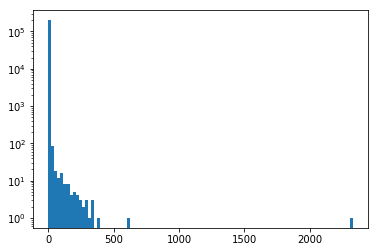

In [34]:
plt.yscale('log', nonposy='clip')
plt.hist(activitiesq,bins=100);

In [22]:
# not certain how well this is working : see identical gene indices below , use previous cell in the meantime
gindices=np.zeros(10000,np.int32)
genes=np.zeros(10000,np.uint64)
popln=np.zeros(10000,np.int32)
activities=np.zeros(10000,np.int32)

nspecies=g.genelife.get_sorted_popln_act(gindices,genes,popln,activities)  #nspecies is only those with popcount nonzero
print("no of species",nspecies,len(popln))
print(popln[0:nspecies])
print(genes[0:nspecies])
for i in range(len(activities)):
    if activities[i]: imax = i;
print(imax)


no of species 4 10000
[4631 4621 4247  658]
[                1542 16140901064495859206  6917529027641083398
  2305843009213695494]
3


## Trace of number of live cell statistics

In [ ]:
ntmax = 1024
while g.framenr//g.nstat > ntmax: ntmax = ntmax*2   # increase ntmax to next power of 2 to match C memory
tpts=np.zeros(ntmax,np.int32)
livestats = np.zeros(ntmax,np.int32)
genotypes = np.zeros(ntmax*4,np.int32)
genotypes4 = np.reshape(genotypes,(ntmax,4)).T
stepstats = np.zeros(ntmax*10,np.int32)
stepstats10 = np.reshape(stepstats,(ntmax,10)).T
configstats = np.zeros(ntmax*4,np.int32)
configstats4 = np.reshape(configstats,(ntmax,4)).T

In [ ]:
nt = g.framenr//g.nstat
g.genelife.get_stats(livestats,genotypes,stepstats,configstats,nt)
tpts = [i*g.nstat for i in range(1,nt)]

In [ ]:
%matplotlib inline
# fig, ax = plt.subplots()
g.plt.rcParams['figure.figsize'] = [10, 10]
f, (ax1, ax2, ax3) = g.plt.subplots(3, sharex=True, sharey=False)
ax1.plot(tpts,stepstats10[0][1:nt],'b',label='notgolrul')
ax1.plot(tpts,stepstats10[1][1:nt],'g',label='2_live')
ax1.plot(tpts,stepstats10[2][1:nt],'r',label='3_live')
ax1.plot(tpts,stepstats10[3][1:nt],'c',label='birth')
ax1.plot(tpts,stepstats10[4][1:nt],'m',label='mutation')
ax1.plot(tpts,stepstats10[5][1:nt],'b--',label='2select')
ax1.plot(tpts,stepstats10[6][1:nt],'g--',label='survival')
ax1.plot(tpts,stepstats10[7][1:nt],'r--',label='death')
ax1.plot(tpts,stepstats10[8][1:nt],'k--',label='golstate')
ax1.plot(tpts,stepstats10[9][1:nt],'m--',label='3g_same')
ax2.plot(tpts,genotypes4[0][1:nt],'b',label='d=0 class')
ax2.plot(tpts,genotypes4[1][1:nt],'g',label='d=1 class')
ax2.plot(tpts,genotypes4[2][1:nt],'r',label='d=2 class')
ax2.plot(tpts,genotypes4[3][1:nt],'k',label='d=3 class')
ax3.plot(tpts,configstats4[0][1:nt],'b',label='offset [-1, 0,-1]')
ax3.plot(tpts,configstats4[1][1:nt],'g',label='offset [ 1, 0,-1]')
ax3.plot(tpts,configstats4[2][1:nt],'r',label='offset [ 0,-1,-1]')
ax3.plot(tpts,configstats4[3][1:nt],'k',label='offset [ 0, 1,-1]')
ax1.set_ylabel('number of such cells')
ax2.set_ylabel('number of such cells')
ax3.set_ylabel('number of such configs')
legend1 = ax1.legend(loc=2, bbox_to_anchor=(1,1), shadow=True, fontsize='small')  # or use  loc = 'best'
legend2 = ax2.legend(loc=2, bbox_to_anchor=(1,1), shadow=True, fontsize='small')
legend3 = ax3.legend(loc=2, bbox_to_anchor=(1,1), shadow=True, fontsize='small')
legend1.get_frame().set_facecolor('C0')
legend2.get_frame().set_facecolor('C0')
legend3.get_frame().set_facecolor('C0')
g.plt.show()

## Space-time of one row

In [ ]:
g.genelife.get_curgol(g.gol)
cnt = range(g.N)
for i in range(g.N):
    cnt[i] = sum([g.gol[(i*g.N)+j] for j in range(g.N)])

In [ ]:
foo = [(i,cnt[i]) for i in range(g.N) if cnt[i] == max(cnt)]

myrow = foo[0][0]
for i in range(g.N):
    g.genelife.get_curgol(g.gol)
    for j in range(g.N):
        if g.gol[(g.N*myrow)+j]==1:
            g.cgrid[i][j] = 1
        else:
            g.cgrid[i][j] = 0
    g.genelife.genelife_update(1,0,0)
    

In [ ]:
%matplotlib inline

In [ ]:
my_dpi=96
my_cmap = g.rand_cmap(257, type='bright', first_color_black=True, last_color_black=False)

fig, ax = g.plt.subplots(figsize=((3*256)/my_dpi, (3*256)/my_dpi), dpi=my_dpi, frameon=False)
ax.axis('off')
# mat = ax.matshow(cgrid, cmap=my_cmap, vmin=0.01, vmax=257)  # was vmax = LEN+1
mat = ax.matshow(g.cgrid, cmap=my_cmap, vmin = 0, vmax = 56)
g.plt.show()

# Gallery of example simulations
use ctrl-return to execute cell and stay on same cell

## Selection 0  Numerical value of gene determines fitness

In [ ]:
# 0
#  selection=0 gene value
#  Note that sequences must differ for replication unless it is forced.
#   
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=100;  # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;              # single step
g.nhist = 10                                     # set to n to turn on histogram configurations every nth step
g.nstat = 10                                     # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1                   # 0,1 whether to allow GoL rule modifications
                                                 # if 0, gene dynamics consistent with GoL still possible
g.repscheme = g.runparams[1] = 0x3               # bits 0 to 13 code for binary options, 14-20 code for quadrant pairs,
                                                 # 21-24 for allowed canonical 2-live nb configs 
                                                 # value 0x11 is simply game of life provided survivalmask is 3
g.selection = g.runparams[2] = 0                 # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.survivalmask = g.runparams[4] = 2              # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.birthmask = 1                                  # birth mask for two (bit 1) and three (bit 0) live neighbours : GoL = 1
g.overwritemask = g.runparams[3] = 3             # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs

g.colorfunction = g.runparams[5] = 0             # color function 0(hash), ≥1(fnal), 2 nongolchg yellow, 3 notgolrul yellow
g.initfield = g.runparams[6] = 200               # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8                 # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 16384       # initial 1 density in GOL state
                                                 # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0           # initial density of random genes
g.ncoding = g.simparams[3] = 0                   # bits0-7 no of bits used to encode individual gene functions
                                                 # bits8-15 no of bits to encode masks for add2ndmask1st functions
                                                 # bits 16-23 number of planes used in selection modesl 10-12 
g.startgenechoice = g.simparams[4] = 8           # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, True)

## Selection 1 Number of 1s in gene determines fitness

In [ ]:
# 1
#  selection=1 number of ones determines fitness
#  Note that sequences must differ in number of ones for replication unless it is forced.
#  ncoding plays no role, system takes about 4-5000 steps to reach all ones sequence
#  Color scheme: color gradient with colors going from black (no 1s) to white (all 1s)
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=100;  # simulation time stepping parameters
g.nhist = 0                                      # set to n to turn on histogram configurations every nth step
g.nstat = 0                                      # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1                   # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x3               # bit 0,1 on allow selection in 3,2 live nb configs
g.selection = g.runparams[2] = 1                 # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x3           # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 2              # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.colorfunction = g.runparams[5] = 1             # color function 0-8
g.initfield = g.runparams[6] = 200               # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8                 # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 16384       # initial 1 density in GOL state
g.initialrdensity = g.simparams[2] = 0           # initial density of random genes
g.ncoding = g.simparams[3] = 0                   # no of bits used to encode valid connection functions 1-16
g.startgenechoice = g.simparams[4] = 8           # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 2 Not well-ordered (tournament) selection - scissors-stone-well-paper model

In [ ]:
# 2
#  selection=2 scissors-stone-well-paper
#  Note that sequences must differ for replication unless it is forced.
#  
#  Color scheme: four different classes are red, green, blue and white
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=100;  # simulation time stepping parameters
g.nhist = 10                                # set to n to turn on histogram configurations every nth step
g.nstat = 10                                # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1              # 0,1 whether to allow GoL rule modifications
                                            # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x3          # bits 0 to 20 code for mostly independent binary options
g.selection = g.runparams[2] = 2            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 3        # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 0         # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.colorfunction = g.runparams[5] = 1        # color function 0(hash), ≥1(fnal), 2 nongolchg yellow, 3 notgolrul yellow
g.initfield = g.runparams[6] = 200          # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8            # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 8192   # initial 1 density in GOL state
                                            # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0      # initial density of random genes
g.ncoding = g.simparams[3] = 0              # no of bits used to encode valid connection functions 1-16
g.startgenechoice = g.simparams[4] = 8      # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0(False)
#step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 3 Cyclic not well-ordered selection for 4 species

In [ ]:
# 3
#  selection=3 scissors-stone-well-paper but only next color wins
#  Note that sequences must differ for replication unless it is forced.
#  
#  Color scheme: four different classes are red, green, blue and white
nrun=1; ndisp=1000; nskip=0; niter=100;  # simulation time stepping parameters
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 3               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 0x2ab         # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
selection = runparams[2] = 3             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 0         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 0          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 1         # color function 0-8
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0               # not used in selection==2
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
#step()
run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 4 Cooperative birth requiring two individuals with different gene functions

In [ ]:
# 4
#  selection=4 cooperative birth between near-0 and near-1 sequences with appropriate parameters for survival
#  Note that since two different sequences that cannot mutate directly into oneanother are required, birth is difficult
#  The system needs some non selective birth to proliferate : overwritemask 3
#  For random start the ncoding value must be large, 28 or so.
#  Color scheme: green near 0, read near 1, white neither. Near means within ncoding bits. 
nrun=1; ndisp=200; nskip=0; niter=100;   # simulation time stepping parameters : set nskip=800 for faster long time
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 0x03          # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
selection = runparams[2] = 4             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 3         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 2          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 1         # color function 0-8
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 12              # no of bits away from targets and each other allowed for match
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
#step()
run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 5 Predator-prey model

In [ ]:
# 5
#  selection=5 with appropriate parameters for survival
#  Note that since two different sequences that cannot mutate directly into oneanother are required, birth is difficult
#  The system needs some non selective birth to proliferate : enforce birth with repscheme bits 3,4
#  Predator and prey must be within ncoding bits of one another
g.nrun=1; g.ndisp=200; g.nskip=800; g.niter=100; # simulation time stepping parameters
g.nhist = 0                                      # set to n to turn on histogram configurations every nth step
g.nstat = 0                                      # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1                   # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 0x33              # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
g.selection = g.runparams[2] = 5                 # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 3             # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 2              # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
g.colorfunction = g.runparams[5] = 1             # color function 0-8
g.initfield = g.runparams[6] = 200               # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7                 # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] = 16384       # initial 1 density in GOL state
g.initialrdensity = g.simparams[2] = 0           # initial density of random genes
g.ncoding = g.simparams[3] = 8                   # no of bits used to encode valid connection functions 1-16
g.startgenechoice = g.simparams[4] = 8           # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 6 Constrained selection involving two targets and distance constraint

In [ ]:
# 6
#  selection=6 with appropriate parameters for survival
#  in this model there are two target gene centres at all 0 sequence and the sequence with ncoding leading 1s
#  birth occurs if the two sequences have different distances to each target and these are less than their mutual distance
# the sequence which is closer to its target in selected as the ancestor for birth
# the initial asymmetry was corrected by disallowing equal distances to the targets (a biassed choice was made)
# one can enforce birth using repscheme, in which case the canonical rotation is used to maintain symmetry
nrun=1; ndisp=200; nskip=0; niter=1;       # simulation time stepping parameters
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 0               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 7             # for selection 10 or 11, repscheme gives number of planes in simulation (0->16)
selection = runparams[2] = 6             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3]= 0x0        # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 0x3        # selection 10,11: survival bit 0 determines if current plane used as well for nbs
colorfunction = runparams[5] = 0         # color function 0-8
initfield = runparams[6] = 150            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] =  16384  # initial 1 density in GOL state
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0               # number of bits coding for functions
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
# step()
run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 7 Neutral but different

In [ ]:
# 7
#  selection=7 with appropriate parameters for survival
#  in this version selection is neutral, but fails if the sequences are the same
g.nrun=1; g.ndisp=200; g.nskip=0; g.niter=1;       # simulation time stepping parameters
g.nhist = 0                                # set to n to turn on histogram configurations every nth step
g.nstat = 0                                # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
g.repscheme = g.runparams[1] = 3             # for selection 10 or 11, repscheme gives number of planes in simulation (0->16)
g.selection = g.runparams[2] = 7             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3]= 0x0        # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
g.survivalmask = g.runparams[4] = 0x3        # selection 10,11: survival bit 0 determines if current plane used as well for nbs
g.colorfunction = g.runparams[5] = 0         # color function 0-8
g.initfield = g.runparams[6] = 150            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # number of bits coding for functions
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 8 Totalistic LUT encoded by gene (fixed length direct encoding)

Note the new overwritemask functionality and buttons to control it in red.

In [ ]:
#  8 
#  selection=8 sum totalistic LUT with appropriate parameters for survival and genes encoding LUt in fixed length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth is determined by the and of the live neighbour genes (bits 8-15 for ncoding=1) ie genecode
#  survival is determined the and of the live neighbour genes (bits 0-8 for ncoding=1) ie genecode
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=100; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x170         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed
g.selection = g.runparams[2] = 8             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x6       # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x0        # GoL constraint if genes stay active
#g.birthmask = g.runparams[7] = 0x6          # GoL constraint if genes stay active 
g.birthmask = g.runparams[7] = 0xe           # 
g.colorfunction = g.runparams[5] = 9         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 200           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
# display colors used in colorfunction 10 activities mode size (once "p" pressed)
i= 0;
for colr in [0x800000FF, 0xE40000FF, 0xFF4A00FF, 0xFFAD00FF, 0xECFF13FF, 0x87FF78FF, 0x23FFDCFF, 0x00BDFFFF, 0x005AFFFF, 0x0000F5FF, 0x00008FFF]:
    g.pg.draw.rect(g.scr,colr,[i,i,20,20])
    i=i+20
g.pg.transform.scale2xact(g.scr,g.screen)
g.pg.display.update() 

In [ ]:
maxsmallpatts = 65536
# smallpattdtype defined in genelife_update_module.py
# smallpattdtype=[('topactivity',c_uint32),('activity',c_uint32),('firsttime',c_uint32),('lasttime',c_uint32)]
# print g.genelife.smallpattdtype
smallpatts = np.zeros(maxsmallpatts,dtype=g.genelife.smallpattdtype)
nsmallpatts=g.genelife.get_smallpatts(smallpatts)
print 'nsmallpatts',nsmallpatts
# output table of first 100 values
print '   patt size topactivity activity  firsttime  lasttime'
for i in range(1,100):
    if i<=1: log2n = 0
    else: log2n = int(1+np.log2(int(np.sqrt(i-1)))) 
    print " %6d %4d %8d %8d %10d %10d" % (i, log2n, smallpatts[i]['topactivity'], smallpatts[i]['activity'], smallpatts[i]['firsttime'],smallpatts[i]['lasttime'])
histnodes = np.zeros(10)
for i in range(1:len(smallpatts)):
    if (smallpatts[i]['activity']):
        if i<=1: log2n = 0
        else: log2n = int(1+np.log2(int(np.sqrt(i-1))))  
        histnodes[log2n]=histnodes[log2n]+1
for i in range(10):
    print i,'%7d' % histnodes[i],'out of possible 2^',2**(2*i),'-1'

In [ ]:
# tutorial in transparency : https://riptutorial.com/pygame/example/23788/transparency
# note that surfaces with by pixel transparency are slower
import pygame
pygame.init()

WHITE = (255, 255, 255)
BLACK = (0, 0, 0)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
BLUE = (0, 0, 255, 50)  # This color contains an extra integer. It's the alpha value.
PURPLE = (255, 0, 255)

screen = pygame.display.set_mode((200, 325))
screen.fill(WHITE)  # Make the background white. Remember that the screen is a Surface!
clock = pygame.time.Clock()

size = (50, 50)
red_image = pygame.Surface(size)
green_image = pygame.Surface(size)
blue_image = pygame.Surface(size, pygame.SRCALPHA)  # Contains a flag telling pygame that the Surface is per-pixel alpha
purple_image = pygame.Surface(size)

red_image.set_colorkey(BLACK)
green_image.set_alpha(50)
# For the 'blue_image' it's the alpha value of the color that's been drawn to each pixel that determines transparency.
purple_image.set_colorkey(BLACK)
purple_image.set_alpha(50)

pygame.draw.rect(red_image, RED, red_image.get_rect(), 10)
pygame.draw.rect(green_image, GREEN, green_image.get_rect(), 10)
pygame.draw.rect(blue_image, BLUE, blue_image.get_rect(), 10)
pygame.draw.rect(purple_image, PURPLE, purple_image.get_rect(), 10)

while True:
    clock.tick(60)

    for event in pygame.event.get():
        if event.type == pygame.QUIT:
            quit()
        elif event.type == pygame.KEYDOWN:
            if event.key == pygame.K_1:
                screen.blit(red_image, (75, 25))
            elif event.key == pygame.K_2:
                screen.blit(green_image, (75, 100))
            elif event.key == pygame.K_3:
                screen.blit(blue_image, (75, 175))
            elif event.key == pygame.K_4:
                screen.blit(purple_image, (75, 250))

    pygame.display.update()

In [ ]:
g.set_params()
g.genelife.initialize(g.runparams,g.simparams)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 9 Totalistic LUT encoded by gene with variable length encoding

In [ ]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x660 
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x6       # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x06       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x04          # 8 bit birth mask for allowing genes to modify LUTs
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  8192   # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### Stable population with occasional propagating waves

* genetically stable population (high flying waves) with room for lots of lower waves.
* propagating fronts look a little like reaction diffusion fronts.  
* propagating fronts may diminish after long time (> ~10k steps)

In [9]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x660 
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0         # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x01       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x0d          # 8 bit birth mask for allowing genes to modify LUTs
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000   # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 2       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### Asymptotic dynamics with 2 time scales

* slow time scale: quasi-static islands
* fast time scale: fast dynamics in between the islands, gradually changing island boundaries.
* mess with `survivalmask` to change nature of islands (e.g. `0xd`, `0x1d`)
* seems to be ongoing evolution on both time scales.
* at `t=25000`, hit `Expanding hash table items at table count 262144`

In [ ]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x660 
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0         # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x03       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x0d          # 8 bit birth mask for allowing genes to modify LUTs
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000   # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 2       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

with `survivalmask = 0x9d`:

In [8]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x660 
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0         # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.survivalmask = g.runparams[4] = 0x1d       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x0d          # 8 bit birth mask for allowing genes to modify LUTs
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000   # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 2       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

step 299 colorfunction changed to 10
step 327 colorfunction changed to 9
step 351 colorfunction changed to 10
step 371 colorfunction changed to 0
step 378 colorfunction changed to 1
step 384 colorfunction changed to 2
step 388 colorfunction changed to 3
step 392 colorfunction changed to 4
step 678 colorfunction changed to 3
step 683 colorfunction changed to 2
step 685 colorfunction changed to 1
step 687 colorfunction changed to 0
step 693 colorfunction changed to 10
step 741 colorfunction changed to 9
step 753 colorfunction changed to 10
step 765 colorfunction changed to 0
step 773 colorfunction changed to 1
step 779 colorfunction changed to 0


In [ ]:
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### Long interesting transient

Ends with interesting variegated static cruft, with evolutionarily stable dynamics between.

In [7]:
#  9 
#  selection=9 sum totalistic LUT with appropriate parameters for survival and genes encoding LUT in variable length direct encoding
#  this case uses the genes to encode the totalistic (s dept) rule tables for birth and survival
#  birth rules are encoded as 1xxx where xxx is sum-1 of live neighbours and survival rules by 0xxx
#  birth is determined by the existence of a 4-bit birth rule somewhere  in the live neighbour genes for current s=1-8
#  survival is determined by the existence of a 4-bit survival rule somewhere  in the live neighbour genes for current s=1-8
#  in an alternative version (see commented line in update_lut_sum) survival is by the central live neighbour gene
#  ncoding may be set (1-7) to require more bits of gene be 1 to turn on a rule
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x660 
g.selection = g.runparams[2] = 9             # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
                                             # for selection=9 this is the birth mask
g.survivalmask = g.runparams[4] = 0xff       # 8 bit survival mask for allowing genes to modify LUTs
g.birthmask = g.runparams[7] = 0x0a          # 8 bit birth mask for allowing genes to modify LUTs
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000   # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0x1             # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 2       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

step 813 colorfunction changed to 10
step 841 colorfunction changed to 9
step 917 colorfunction changed to 8
step 922 colorfunction changed to 7
step 930 colorfunction changed to 6
step 932 colorfunction changed to 5
step 937 colorfunction changed to 4
step 941 colorfunction changed to 3
step 947 colorfunction changed to 2
step 949 colorfunction changed to 1
step 953 colorfunction changed to 0
step 964 colorfunction changed to 10
step 966 colorfunction changed to 9
step 1054 colorfunction changed to 10
step 1078 colorfunction changed to 0
step 1098 colorfunction changed to 1
step 1109 colorfunction changed to 2
step 1118 colorfunction changed to 3
step 1122 colorfunction changed to 4
step 1158 colorfunction changed to 5
step 1167 colorfunction changed to 6
step 1176 colorfunction changed to 7
step 1180 colorfunction changed to 8
step 1185 colorfunction changed to 9
step 1193 colorfunction changed to 10
step 1202 colorfunction changed to 9
step 1210 colorfunction changed to 10
step 1215

In [ ]:
g.set_params()
g.genelife.initialize(g.runparams,g.simparams)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 10 Distance distinguishing LUT encoded by gene with fixed length positional encoding

In [6]:
# 10
#  selection=10 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a fixed positional encoding is used in the gene with 1 bit per valid s,se combination
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 23 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=4; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x640         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 10        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x6       # mask of bits to overwrite if birth allowed and already occupied for bit position sum s
g.birthmask    = g.runparams[7] = 0x000001e0 # for selection=8-13 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x000001fc # for selection=10-11 this is the GoL survival mask
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 2               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
#g.step(True)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
g.set_params()
g.genelife.initialize(g.runparams,g.simparams)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 11 Distance distinguishing LUT encoded by gene with variable length encoding

In [ ]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 19 cases s=2-6 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 19 bits of overwritemask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x0610        # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x000001e0 # for selection=10-13 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x000001fc # for selection=10-11 this is the GoL survival mask
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
g.set_params()
g.genelife.initialize(g.runparams,g.simparams)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### Simple interesting case : 2/3 of the 3 birth sum 2 LUT entries allowed, nothing else
Initiate with GOL masks B 0x1e0 and S 0x1fc and then add top two sum=2 birth LUT entries 
Then take away all survival entries and then all sum=3 birth entries from masks, leaving a short time for the correct genes to be found.
Alternatively, start straight with final masks and do random gene initialization not GoL genes.
The colorfunction 1 detects whole rule entries, and partial GoL rules, and bunches related functions more than colorfunction 0.
Include new example 12.1 to illustrate the power of distinctions : in this case suppressing the all corner case of birth with sum=2.
This is a world of gliders close to that observed in selection 1,2.

In [ ]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 19 cases s=2-6 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 19 bits of overwritemask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x080         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x00000018 # for selection=10-13 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x00000000 # for selection=10-11 this is the GoL survival mask
g.colorfunction = g.runparams[5] = 1         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 32768       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### Long evolving transient to sea of simple gliders

* Initial condition density critical to get a seed that doesn't die.
* Final state seems evolutionarily stable (invasions of mutations are very rare, new waves die out).
* Even "R" periodic perturbation does not perturb final state, genetically.  In 
fact, it seems to stabilize it.
* Final state has 1-d fractal triangle space time cross section (see below).

**Could the interacting gliders be "performing a computation"?  If yes, we have a case of evolution to computation.**

In [ ]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x110         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x000000f8 # 
g.survivalmask = g.runparams[4] = 0x0000003f # 
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 256           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 7       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### Competing blooms -> stationary competition

In [ ]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x110         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x000000fe # 
g.survivalmask = g.runparams[4] = 0x0000003f # 
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 256           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 7       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

### Another long transient, to more complex competitive mix

In [ ]:
# 11
#  selection=11 LUT with appropriate parameters for survival
#  this case uses the genes to encode the se (number of live edge-centred sites) and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+4 bits, 4-bits for the survival and birth s value as in 8, and 4 bits for the se value
#  there are 1,2,3,4,5,4,3,2,1 configurations of se for s=0-8. Only 23 cases s=1-7 are lut allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 23 bits of birthmask) ie genecode
#  survival is determined the and of the live neighbour genes (and 19 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example starts with only allowing GoL configurations : extend by adding more bits to survival and birth masks
g.nrun=1; g.ndisp=1000; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x110         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection     = g.runparams[2] = 11        # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3] = 0x00
g.birthmask    = g.runparams[7] = 0x000000da # 
g.survivalmask = g.runparams[4] = 0x0000003f # 
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 256           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  10000  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 10000       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 7       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
g.genelife.get_curgol(g.gol)
cnt = range(g.N)
for i in range(g.N):
    cnt[i] = sum([g.gol[(i*g.N)+j] for j in range(g.N)])

In [ ]:
foo = [(i,cnt[i]) for i in range(g.N) if cnt[i] == max(cnt)]

myrow = foo[0][0]
for i in range(g.N):
    g.genelife.get_curgol(g.gol)
    for j in range(g.N):
        if g.gol[(g.N*myrow)+j]==1:
            g.cgrid[i][j] = 1
        else:
            g.cgrid[i][j] = 0
    g.genelife.genelife_update(1,0,0)
    

In [ ]:
%matplotlib inline

my_dpi=96
my_cmap = g.rand_cmap(257, type='bright', first_color_black=True, last_color_black=False)

fig, ax = g.plt.subplots(figsize=((3*256)/my_dpi, (3*256)/my_dpi), dpi=my_dpi, frameon=False)
ax.axis('off')
# mat = ax.matshow(cgrid, cmap=my_cmap, vmin=0.01, vmax=257)  # was vmax = LEN+1
mat = ax.matshow(g.cgrid, cmap=my_cmap, vmin = 0, vmax = 56)
g.plt.show()

In [ ]:
dir(g)

In [ ]:
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 12 Canonical rotation LUT encoded by gene with fixed length positional encoding

In [ ]:
# 12
#  selection=12 LUT with appropriate parameters for survival
#  this case uses the genes to encode the canonical rotation and s dept rule tables for birth and survival
#  a fixed positional encoding is used in the gene with 1-bit for each canonical rotation in the 32 bit survival and birth masks
#  there are 1,1,4,7,10,7,4,1,1 canonical rotation mask bits for s=0-8. Only 32 cases s=2-6 in LUT are allowed non-zero.
#  birth is determined by the and of the live neighbour genes (and 32 bits of overwritemask) ie genecode
#  survival is determined the and of the live neighbour genes (and 32 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
#  this example allows only one of the 4 canonical rotations for s=2 to be gene activated for birth, otherwise <=GoL
g.nrun=1; g.ndisp=100; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x641         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection = g.runparams[2] = 12            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3]= 0x0        # 
g.birthmask = g.runparams[7]= 0x000007f0     # for selection=8-13 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x000007ff # for selection=8-13 this is the GoL survival mask
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0(False)
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, True)

## Selection 13 Canonical rotation LUT encoded by gene with variable length encoding

In [ ]:
# 13
#  selection=13 LUT with appropriate parameters for survival
#  this case uses the genes to encode the canonical rotation and s dept rule tables for birth and survival
#  a variable length encoding is used in the gene with 4+1+5 bits, 4-bits for the survival and birth s value as in 8,
#  and 5 bits for subset of canonical rotations (1/2) determined by 1 further bit.
#  there are 1,1,4,7,10,7,4,1,1 canonical rotation masks for s=0-8. Only 32 cases s=2-6 are lut allowed non-zero.
#  birth is determined by existence of an entry from any of the live neighbour genes (and 32 bits of overwritemask) ie genecode
#  survival determined by existence of an entry from any of the live neighbour genes (and 32 bits of survivalmask) ie genecode
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=1; g.ndisp=100; g.nskip=0; g.niter=1; # simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x80          # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed
g.selection = g.runparams[2] = 13            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3]= 0x0        #
g.birthmask = g.runparams[7]= 0x000007f0     # for selection=12-13 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x000007ff # for selection=12-13 this is the GoL survival mask
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 150           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 16384       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0()
# g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
g.set_params()
g.genelife.initialize(g.runparams,g.simparams)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 14 Symmetric 2D LUT encoded by gene with fixed length positional encoding

In [ ]:
# 14
#  selection=14 LUT with appropriate parameters for survival
#  this case uses the genes to encode all possible configuration rule tables (up to spatial symmetry (4-rotations, 4-reflections)) for birth and survival
#  a fixed length encoding is used in the gene with 1-bit for each of 64 configurations in the 32 bit survival and 32 bit birth masks
#  there are 1,2,6,10,13,10,6,2,1 configuration mask bits for s=0-8. Only 32 cases s=0-4 in LUT are allowed non-zero in this implementation.
#  birth and survival are determined by the presence of a bit in the gene at the position of the symmetric live-nb pattern LUT 
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=1; g.ndisp=100; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x660         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection = g.runparams[2] = 14            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3]= 0x0        # 
g.birthmask = g.runparams[7]    = 0x7fe00    # for selection=8-13 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x7fff8    # for selection=8-13 this is the GoL survival mask
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 16384   # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0(False)
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, True)

## Selection 15 Symmetric 2D LUT encoded by gene with fixed length positional encoding

In [ ]:
# 15
#  selection=15 LUT with appropriate parameters for survival
#  this case uses the genes to encode all possible configuration rule tables (up to spatial symmetry (4-rotations, 4-reflections)) for birth and survival
#  a modular encoding is used in the gene with 12-bit modules for subsets of up to 6 configurations in the 32 bit survival and 32 bit birth masks
#  there are 1,2,6,10,13,10,6,2,1 configuration mask bits for s=0-8. Only 32 cases s=0-4 in LUT are allowed non-zero in this implementation.
#  birth and survival are determined by the presence of a module with the correct pattern in the gene
#  ncoding not used : only space for 1 bit per lut entry
g.nrun=1; g.ndisp=100; g.nskip=0; g.niter=1;# simulation time stepping parameters
g.nhist = 0                                  # set to n to turn on histogram configurations every nth step
g.nstat = 0                                  # set to n to turn on statistics trace every nth step
g.rulemod = g.runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                             # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
g.repscheme = g.runparams[1] = 0x610         # repscheme bit 3 (val 0x8) determines whether random choice of ancestor amongst live neighbours
                                             # repscheme mod 8 i.e. 0-7 determines selection scheme based on gene
                                             # 0 minimum gene as value  # 1 maximum gene as value
                                             # 2 minimum number of ones # 3 maximum number of ones
                                             # 4 neutral selection # 5 neutral but different selection
                                             # 6 penalty function -1 for a survival rule -2 for a birth rule  # 7 not allowed 
g.selection = g.runparams[2] = 15            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
g.overwritemask = g.runparams[3]= 0x0        # 
g.birthmask = g.runparams[7]    = 0x7fe00    # for selection=8-13 this is the GoL birth mask
g.survivalmask = g.runparams[4] = 0x7fff8    # for selection=8-13 this is the GoL survival mask
g.colorfunction = g.runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                             # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
g.initfield = g.runparams[6] = 100           # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
g.nlog2pmut = g.simparams[0] = 8             # log2 gene mutation probability (0 or >56 means no mutation)
g.initial1density = g.simparams[1] =  16384  # initial 1 density in GOL state
                                             # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
g.initialrdensity = g.simparams[2] = 0       # initial density of random genes
g.ncoding = g.simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                             # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
                                             # for selection==8, lut, ncoding 1,2,3 bits per lut entry : 0 implies 3.
g.startgenechoice = g.simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

g.genelife.initialize_planes(g.npoffsets)
g.genelife.initialize(g.runparams,g.simparams)
g.framenr = 0
g.cnt=0
g.show0(False)
#g.step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, True)

In [ ]:
g.set_params()
g.genelife.initialize(g.runparams,g.simparams)
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 16 GoL planes (2-16) coupled pairwise as specified by genes

In [ ]:
# 16
#  selection=16 with appropriate parameters for survival
#  this model involves gene encoded coupling between up to 16 parallel planes of game of life : packed into 64-bit word
#  the coupling makes bits on at most one other plane visible to first plane : locally dept on gene
nrun=1; ndisp=100; nskip=0; niter=1;     # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                         # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
repscheme = runparams[1] = 0x1b          # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
                                         # bit 2 on do 2nd-nb model, bit 3,4 on enforce birth for failed selection with s=3,2
                                         # bit 5 on do position dept 2-live-nb birth 
                                         # bit 6 on for gene encoded 1st neighbour masking
                                         # bit 7 on for check last state change not caused by non GoL rule
                                         # bit 8 extend previous check to all neighbours of site
selection = runparams[2] = 16            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 0         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 0          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 color combined gol states, 3 notgolrul yellow
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] = 16384   # initial 1 density in GOL state
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 32768   # initial density of random genes
ncoding = simparams[3] = 0x100004        # no of bits used to encode valid connection functions 1-16
startgenechoice = simparams[4] = 16      # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0(False)
#step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

## Selection 18 GoL planes (2-16) each coupled to 2 or 4 nearby planes as specified by genes

In [ ]:
# 18
# up to 16 parallel planes of GoL with coupling with genetically encoded subset of up to 4 nearest planes
# in this case all 16 planes used repscheme 0
nrun=1; ndisp=100; nskip=0; niter=1;     # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                         # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
repscheme = runparams[1] = 0x1b          # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
                                         # bit 2 on do 2nd-nb model, bit 3,4 on enforce birth for failed selection with s=3,2
                                         # bit 5 on do position dept 2-live-nb birth 
                                         # bit 6 on for gene encoded 1st neighbour masking
                                         # bit 7 on for check last state change not caused by non GoL rule
                                         # bit 8 extend previous check to all neighbours of site
selection = runparams[2] = 18            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 0         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 0          # survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 1         # color function 0(hash), ≥1(fnal), 2 color gol planes, 3 notgolrul yellow
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 6             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] =  16384  # initial 1 density in GOL state
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 0       # initial density of random genes
ncoding = simparams[3] = 0x100000        # 16 planes also achieved with value 0
startgenechoice = simparams[4] = 16      # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0(False)
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, True)

## Selection 20 64-plane GoL with simple coupling

## Selection 24 Coupling of two planes of GoL by gene specified matching between configurations

In [ ]:
# 24
nrun=1; ndisp=100; nskip=0; niter=1;     # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
                                         # with rulemod 1 2-live-nb birth, 3-live-nb non-birth & non-survival possible
repscheme = runparams[1] = 0             # for selection 10 or 11, repscheme gives number of planes in simulation (0->16)
                                         # 0-1f: bit 0 on allow selection in 3 live nb configs, bit 1 on most difft vs 0 bit of canonical rotation
                                         # bit 2 on do 2nd-nb model, bit 3,4 on enforce birth for failed selection with s=3,2
                                         # bit 5 on do position dept 2-live-nb birth 
                                         # bit 6 on for gene encoded 1st neighbour masking
                                         # bit 7 on for check last state change not caused by non GoL rule
                                         # bit 8 extend previous check to all neighbours of site
                                         # bits 9-12 zusammen mit bit 5, chose only 1 of 4 canonical 2nb configs for birth
selection = runparams[2] = 24            # fitness for 2 live neighbor rule : 0-6 see subgenelife.c code
overwritemask = runparams[3] = 0         # mask of 2 bits to overwrite instead of survival for 3(bit0) or 2(bit1) live nbs
survivalmask = runparams[4] = 3          # selection 10,11: survival bit 0 determines if current plane used as well for nbs
                                         #                  survival bit 1 determines if gol state 1 survives as in gol
                                         # selection<10: survive mask for two (bit 1) and three (bit 0) live neighbours : GoL = 3
colorfunction = runparams[5] = 0         # color function 0(hash), ≥1(fnal), 2 nongulstate or color gol planes, 3 notgolrul yellow
                                         # 4 activities 5 genealogy steps 6 genealogy temporal 7 activity scaled colors
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 9             # log2 gene mutation probability (0 or >56 means no mutation)
initial1density = simparams[1] =  16384  # initial 1 density in GOL state
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 32768   # initial density of random genes
ncoding = simparams[3] = 0               # for selection 10, non zero value means grow plane community from 0
                                         # otherwise (selection<10) no of bits used to encode valid connection functions 1-16
startgenechoice = simparams[4] = 8       # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0()
# step()
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, False)

In [ ]:
# 20
# 64 copies of game of life computed in overlay and in parallel
# for rulemod=0 uncoupeld copies of gol : need to set density of 
# first attempts to explore this model with coupling lead to over-proliferation
# even when coupling only two specific planes specified by the genes
# genes however are not yet proliferating : ie fixed and stationary
nrun=1; ndisp=1000; nskip=0; niter=1;     # simulation time stepping parameters
#nrun=1; ndisp=1; nskip=0; niter=1;      # single step
nhist = 0                                # set to n to turn on histogram configurations every nth step
nstat = 0                                # set to n to turn on statistics trace every nth step
rulemod = runparams[0] = 1               # 0,1 whether to allow GoL rule modifications
repscheme = runparams[1] = 0x11          # bit 0 0: pure 3D 1: gene coupled 2D-3D 
                                         # bit 1 : only use birth not survival from 2D GoL 
                                         # [bit 2 used for canonical bit decision as in other models]
                                         # bit 4,5,6 specify subsets for 3D survival 56,67,6 instead of 567  
selection = runparams[2] = 20            # selects this case with 64 planes
overwritemask = runparams[3] = 0         # not used
survivalmask = runparams[4] = 0          # not used
colorfunction = runparams[5] = 2         # color function 0(hash), ≥1(fnal), 2 color gol planes, 3 notgolrul yellow
initfield = runparams[6] = 200            # 1 init via 32x32 genepat.dat, n>1 init via nxn rand array
nlog2pmut = simparams[0] = 7             # log2 gene mutation probability (0 or >56 means no mutation) : not yet used
initial1density = simparams[1] =  4096   # initial 1 density in GOL state (in 3D initial density should be between 4096 and 8192 not 16384)
                                         # 16384 = nearest to half of guaranteed C rand max value 32767 = 2**15 - 1
initialrdensity = simparams[2] = 32768   # initial density of random genes
ncoding = simparams[3] = 0x400400        # no of bit planes used is 64, ncoding 2 is 16 bits for genes
startgenechoice = simparams[4] = 16      # initialize genes to startgene number 0-8 : 8 is random choice of 0-7

genelife.initialize_planes(npoffsets)
genelife.initialize(runparams,simparams)
framenr = 0
cnt=0
show0(False)
# step(None) # no counts printed
g.run(g.nrun, g.ndisp, g.nskip, g.niter, g.nhist, g.nstat, True)